This notebook is a demonstration for Video Motion Magnification algorotihm from MIT;

<figure style="text-align: center">
    <img src="1d_demo.png">
    <figcaption style="text-align: center"> Motion Magnification algorithm 1d demonstration. </figcaption>
</figure>

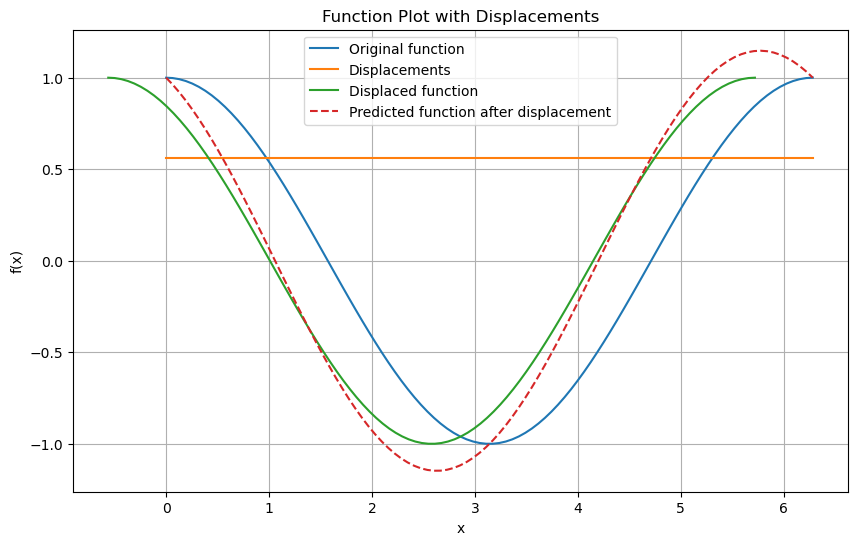

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def f_0(x):
    return np.cos(x)

def f_0_grid(x):
    return -1.0 * np.sin(x)

def disp_func(x, t):
    """Displacement function which input time, t and spatial coordinate, x."""
    
    # we assume the motion is linear with time;
    moving_factor = 1.
    t0 = np.zeros_like(x)

    return moving_factor * np.cos(t) + t0

# Plot function the function curve by plt
def plot_func(x, y):
    plt.plot(x, y)
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title('Function Plot')
    plt.grid(True)
    plt.show()

if __name__ =="__main__":
    # Sample points in function
    x = np.linspace(0, 2 * np.pi, 100)
    y = f_0(x)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label='Original function')
    
    # compute displacements at different x given time t
    delta_t = 1000
    displacements = disp_func(x, delta_t)
    plt.plot(x, displacements, label='Displacements')
    
    # new function curve after displacements
    x_new = x - displacements
    plt.plot(x_new, y, label='Displaced function')

    pred = y + f_0_grid(x) * displacements
    plt.plot(x, pred, label='Predicted function after displacement', linestyle='--')
    
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title('Function Plot with Displacements')
    plt.grid(True)
    plt.legend()
    plt.show()




In the last code section, we could change the frequency of the 1d signal, you will find that the accuracy will dramaticly decrease when the frequency of the signal increase, which is in align with the conclusion from the MIT paper.

---

And the figure above is the situation only have two time stamps, namely t_0 and t, now I would like to coding into more like videos, which means I will make more continuous time stamps, and the AC components of the signal will follow a time function;

Created 1D noisy video dimensions: (128, 200) (space, time)


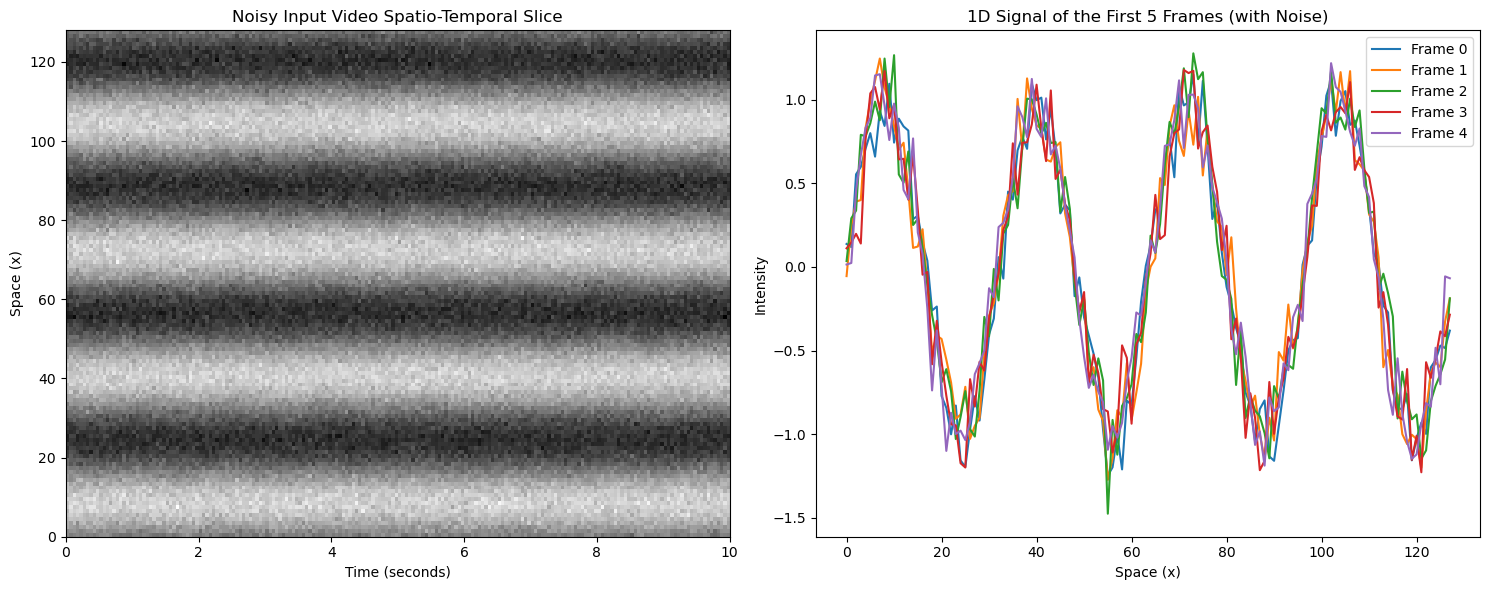

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import cv2 # Using OpenCV for pyramid operations is more convenient

# --- Video Parameters ---
spatial_dims = 128      # Spatial resolution (number of pixels)
n_frames = 200          # Total number of frames
frame_rate = 20         # Frame rate (Hz)
duration = n_frames / frame_rate # Video duration (seconds)

# --- Signal Parameters ---
wavelength = 32         # Spatial wavelength of the sine wave (pixels)
motion_freq = 0.7       # Frequency of the motion (Hz)
motion_amplitude = 0.2  # Amplitude of the motion (pixels), deliberately set to sub-pixel level

# --- Algorithm Parameters ---
alpha = 50              # Amplification factor
low_cutoff = 0.6        # Low cutoff frequency for the bandpass filter (Hz)
high_cutoff = 0.8       # High cutoff frequency for the bandpass filter (Hz)
pyramid_levels = 4      # Number of pyramid levels
noise_std = 0.15        # <<-- NEW: Standard deviation of the added Gaussian noise

# --- Data Generation ---
x = np.arange(spatial_dims)
t = np.linspace(0, duration, n_frames)

# Time-varying small displacement delta(t)
delta_t = motion_amplitude * np.sin(2 * np.pi * motion_freq * t)

# Create space-time grid and generate clean video I(x, t)
T, X = np.meshgrid(t, x)
DELTA_T, _ = np.meshgrid(delta_t, x)
video_1d_clean = np.sin(2 * np.pi / wavelength * (X + DELTA_T))

# <<-- NEW: Add Gaussian noise to simulate a noisy camera
noise = np.random.normal(0, noise_std, video_1d_clean.shape)
video_1d_noisy = video_1d_clean + noise

print(f"Created 1D noisy video dimensions: {video_1d_noisy.shape} (space, time)")

# --- Visualize Input Video ---
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(video_1d_noisy, aspect='auto', origin='lower', extent=[0, duration, 0, spatial_dims], cmap='gray')
plt.title("Noisy Input Video Spatio-Temporal Slice")
plt.xlabel("Time (seconds)")
plt.ylabel("Space (x)")
plt.subplot(1, 2, 2)
for i in range(5):
    plt.plot(video_1d_noisy[:, i], label=f'Frame {i}')
plt.title("1D Signal of the First 5 Frames (with Noise)")
plt.xlabel("Space (x)")
plt.ylabel("Intensity")
plt.legend()
plt.tight_layout()
plt.show()

Pyramid decomposition complete. Total levels: 4.
Level 0 video dimensions: (128, 200)
Level 1 video dimensions: (64, 200)
Temporal filtering for all levels complete.


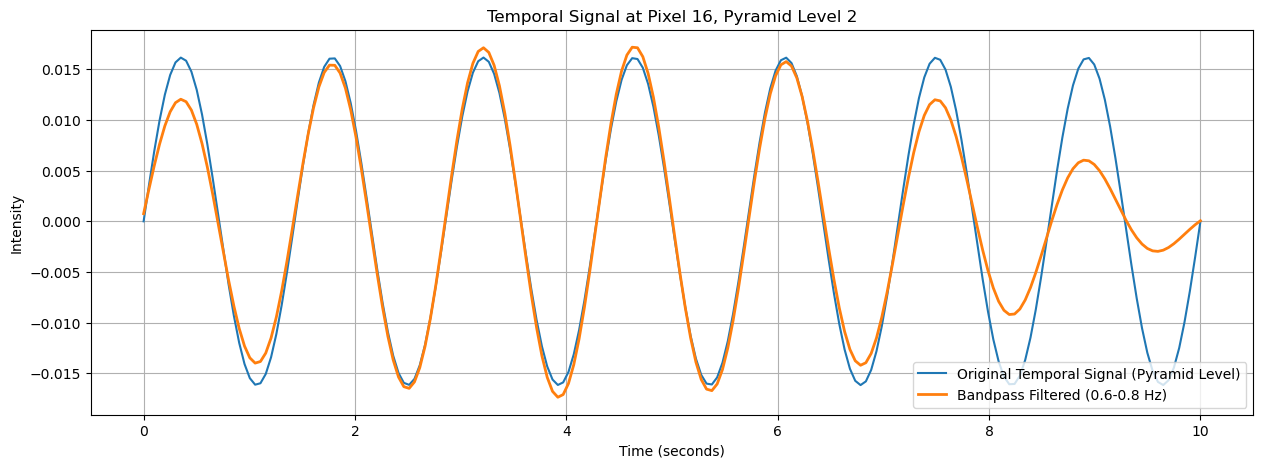

Amplification and reconstruction complete.


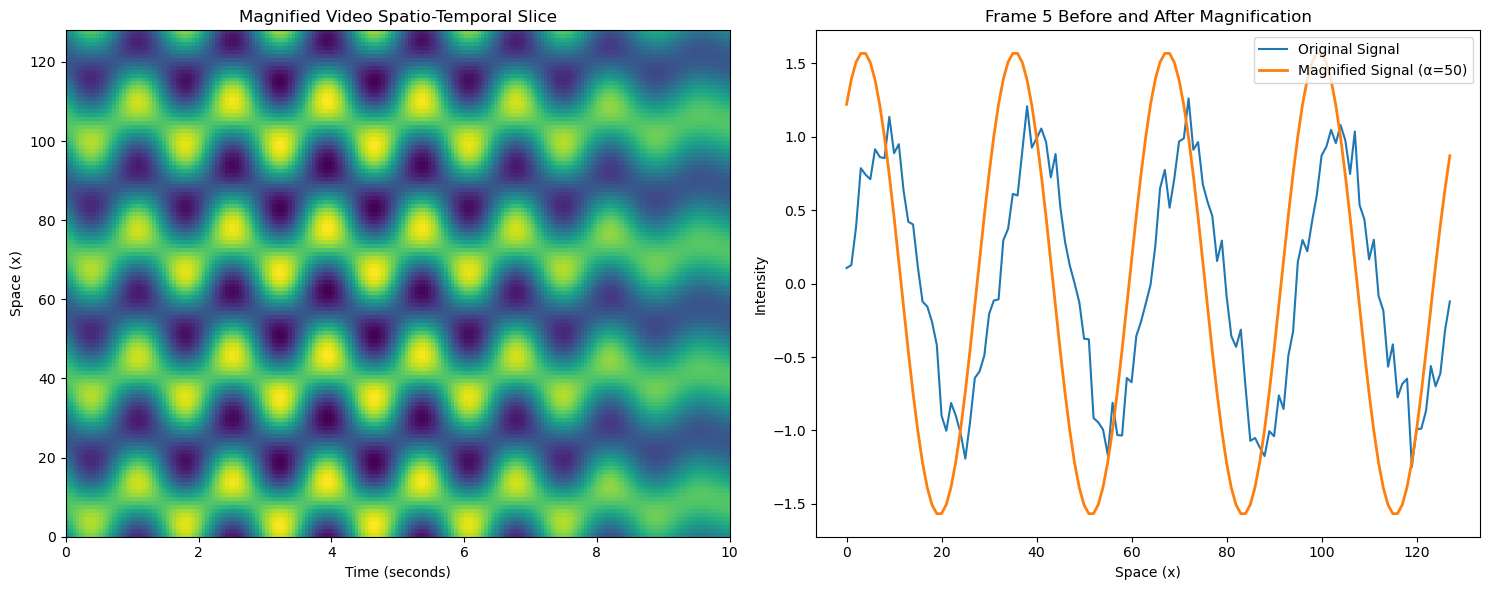

In [ ]:
# --- CORRECTED PYRAMID FUNCTIONS ---
def build_laplacian_pyramid_1d(frame, levels):
    """Build a 1D Laplacian pyramid for a frame."""
    # Reshape 1D frame into a 2D column vector for OpenCV functions
    frame_2d = frame.astype(np.float32).reshape(-1, 1)
    
    gaussian_pyramid = [frame_2d]
    for i in range(levels - 1):
        frame_2d = cv2.pyrDown(gaussian_pyramid[-1])
        gaussian_pyramid.append(frame_2d)

    laplacian_pyramid = []
    for i in range(levels - 1):
        # The dstsize should be (width, height)
        expanded = cv2.pyrUp(gaussian_pyramid[i + 1], dstsize=(1, gaussian_pyramid[i].shape[0]))
        
        # Now subtraction is between two 2D arrays
        laplacian_pyramid.append(gaussian_pyramid[i] - expanded)

    laplacian_pyramid.append(gaussian_pyramid[-1])
    
    # Flatten all levels back to 1D arrays for consistency
    laplacian_pyramid_1d = [level.flatten() for level in laplacian_pyramid]
    return laplacian_pyramid_1d

def collapse_laplacian_pyramid_1d(pyramid):
    """Reconstruct a 1D frame from its Laplacian pyramid."""
    # The pyramid now contains 1D arrays
    # The last level is the smallest Gaussian image, reshape it to 2D
    frame_2d = pyramid[-1].reshape(-1, 1)
    
    for i in range(len(pyramid) - 2, -1, -1):
        # The dstsize should be (width, height)
        expanded = cv2.pyrUp(frame_2d, dstsize=(1, pyramid[i].shape[0]))
        
        # Reshape the laplacian level to add
        laplacian_level = pyramid[i].reshape(-1, 1)
        
        frame_2d = expanded + laplacian_level
        
    return frame_2d.flatten()

# Decompose the entire video into a sequence of pyramids
laplacian_pyramids_video = []
for i in range(n_frames):
    frame_pyramid = build_laplacian_pyramid_1d(video_1d_noisy[:, i], pyramid_levels)
    laplacian_pyramids_video.append(frame_pyramid)

# Transpose the data structure for easier temporal filtering per level
video_pyramid_levels = []
for level in range(pyramid_levels):
    level_video = np.array([laplacian_pyramids_video[frame][level] for frame in range(n_frames)]).T
    video_pyramid_levels.append(level_video)

print(f"Pyramid decomposition complete. Total levels: {len(video_pyramid_levels)}.")
print(f"Level 0 video dimensions: {video_pyramid_levels[0].shape}")
print(f"Level 1 video dimensions: {video_pyramid_levels[1].shape}")


def temporal_bandpass_filter(signal, low, high, fs):
    """Apply a temporal bandpass filter to a signal."""
    nyquist = 0.5 * fs
    low_norm = low / nyquist
    high_norm = high / nyquist
    b, a = butter(2, [low_norm, high_norm], btype='band')
    return filtfilt(b, a, signal)

filtered_pyramid_levels = []
for level_video in video_pyramid_levels:
    filtered_level_video = np.zeros_like(level_video)
    # Process pixel by pixel
    for i in range(level_video.shape[0]):
        pixel_time_series = level_video[i, :]
        filtered_series = temporal_bandpass_filter(pixel_time_series, low_cutoff, high_cutoff, frame_rate)
        filtered_level_video[i, :] = filtered_series
    filtered_pyramid_levels.append(filtered_level_video)

print("Temporal filtering for all levels complete.")

# --- Visualize Filtering Process ---
level_to_show = 2
pixel_to_show = filtered_pyramid_levels[level_to_show].shape[0] // 2
original_signal = video_pyramid_levels[level_to_show][pixel_to_show, :]
filtered_signal = filtered_pyramid_levels[level_to_show][pixel_to_show, :]

plt.figure(figsize=(15, 5))
plt.plot(t, original_signal, label='Original Temporal Signal (Pyramid Level)')
plt.plot(t, filtered_signal, label=f'Bandpass Filtered ({low_cutoff}-{high_cutoff} Hz)', linewidth=2)
plt.title(f"Temporal Signal at Pixel {pixel_to_show}, Pyramid Level {level_to_show}")
plt.xlabel("Time (seconds)")
plt.ylabel("Intensity")
plt.legend()
plt.grid(True)
plt.show()

magnified_pyramid_levels = []

# The paper mentions that alpha can be attenuated for high frequencies to avoid artifacts
alphas = [alpha/4, alpha/2, alpha, alpha] 

for level in range(pyramid_levels):
    # Amplify the filtered signal
    amplified_signal = alphas[level] * filtered_pyramid_levels[level]
    
    # Add it back to the original pyramid level
    magnified_level = video_pyramid_levels[level] + amplified_signal
    magnified_pyramid_levels.append(magnified_level)

# Reconstruct each frame of the video
output_video_1d = np.zeros_like(video_1d_noisy)
for i in range(n_frames):
    # Assemble the pyramid structure for a single frame
    magnified_frame_pyramid = [magnified_pyramid_levels[level][:, i] for level in range(pyramid_levels)]
    
    # Reconstruct the frame
    reconstructed_frame = collapse_laplacian_pyramid_1d(magnified_frame_pyramid)
    output_video_1d[:, i] = reconstructed_frame
    
print("Amplification and reconstruction complete.")

# --- Visualize Final Results ---
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(output_video_1d, aspect='auto', origin='lower', extent=[0, duration, 0, spatial_dims])
plt.title("Magnified Video Spatio-Temporal Slice")
plt.xlabel("Time (seconds)")
plt.ylabel("Space (x)")

frame_to_compare = 5
plt.subplot(1, 2, 2)
plt.plot(video_1d_noisy[:, frame_to_compare], label='Original Signal')
plt.plot(output_video_1d[:, frame_to_compare], label=f'Magnified Signal (α={alpha})', linewidth=2)
plt.title(f"Frame {frame_to_compare} Before and After Magnification")
plt.xlabel("Space (x)")
plt.ylabel("Intensity")
plt.legend()
plt.tight_layout()
plt.show()